# Interpreting Identity

# Setup
(No need to read)

In [1]:
TRAIN_MODEL = True

In [2]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
# Upgrade pip
%pip install --upgrade pip
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")
    ipython.run_line_magic("pip", "install ipympl")
    ipython.run_line_magic("pip", "install scipy")
    ipython.run_line_magic("pip", "install manim")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install circuitsvis
    %pip install ipympl

Note: you may need to restart the kernel to use updated packages.
Running as a Jupyter notebook - intended for development only!


/tmp/ipykernel_239640/863253725.py:24: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_239640/863253725.py:25: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import stuff
import torch
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
from pathlib import Path
import plotly.express as px

import copy

import transformer_lens.utils as utils

from transformer_lens import HookedTransformer, HookedTransformerConfig, ActivationCache

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Define the location to save the model, using a relative path
PTH_LOCATION = "workspace/_scratch/identity.pth"

# Create the directory if it does not exist
os.makedirs(Path(PTH_LOCATION).parent, exist_ok=True)

cuda


# Model Training

## Config

In [4]:
p = 3
frac_train = 1

# Optimizer config
lr = 1e-3
wd = 1e-2
betas = (0.9, 0.999)

num_epochs = 10000
checkpoint_every = 500

DATA_SEED = 598

## Define Task
* Define modular addition
* Define the dataset & labels

Input format:
|a|=|

Convert this to a train + test set - 30% in the training set

In [5]:
def get_training_data(p = p):
    a_vector = torch.arange(p)
    equals_vector = einops.repeat(torch.tensor(p), " -> i", i=p)
    dataset = torch.stack([a_vector, equals_vector], dim=1).to(device)
    print(dataset)
    print(dataset.shape)
    labels = dataset[:, 0]
    print(labels.shape)
    print(labels)
    torch.manual_seed(DATA_SEED)
    indices = torch.randperm(p)
    cutoff = int(p*frac_train)
    train_indices = indices[:cutoff]
    test_indices = indices[cutoff:]

    train_data = dataset[train_indices]
    train_labels = labels[train_indices]
    test_data = dataset[test_indices]
    test_labels = labels[test_indices]
    print(train_data)
    print(train_labels)
    print(train_data.shape)
    print(test_data[:5])
    print(test_labels[:5])
    print(test_data.shape)
    return train_data, train_labels, test_data, test_labels, train_indices, test_indices

train_data, train_labels, test_data, test_labels, train_indices, test_indices = get_training_data(p)

tensor([[0, 3],
        [1, 3],
        [2, 3]], device='cuda:0')
torch.Size([3, 2])
torch.Size([3])
tensor([0, 1, 2], device='cuda:0')
tensor([[2, 3],
        [0, 3],
        [1, 3]], device='cuda:0')
tensor([2, 0, 1], device='cuda:0')
torch.Size([3, 2])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
tensor([], device='cuda:0', dtype=torch.int64)
torch.Size([0, 2])


## Define Model

In [6]:
def get_seeded_model(seed = 999, p = p):
    cfg = HookedTransformerConfig(
        n_layers = 1,
        n_heads = 1,
        d_model = 2,
        d_head = 2,
        d_mlp = 0,
        act_fn = "relu",
        normalization_type=None,
        d_vocab=p+1,
        d_vocab_out=p,
        n_ctx=2,
        init_weights=True,
        device=device,
        seed = seed,
    )
    model = HookedTransformer(cfg)
    for name, param in model.named_parameters():
        if "b_" in name:
            param.requires_grad = False
    return model

model = get_seeded_model(seed = 993)

Disable the biases, as we don't need them for this task and it makes things easier to interpret.

## Define Optimizer + Loss

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()
train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(train_loss)
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(test_loss)
print("Uniform loss:")
print(np.log(p))

tensor(1.1078, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(nan, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Uniform loss:
1.0986122886681098


## Actually Train

**Weird Decision:** Training the model with full batch training rather than stochastic gradient descent. We do this so to make training smoother and reduce the number of slingshots.

In [8]:
def print_stats(model):
    # Extract the p 2-dimensional tensors, vector i is vec[:, i]
    vec = model.W_U.data

    # Function to compute the angle between two vectors
    def compute_angle(v1, v2):
        cos_theta = torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2))
        angle = torch.acos(cos_theta) * (180.0 / np.pi)
        return angle

    # Compute pairwise angles
    for i in range(vec.shape[1]):
        for j in range(i+1, vec.shape[1]):
            angle = compute_angle(vec[:, i], vec[:, j])
            print(f"Angle between {i} and {j}: {angle.item():.2f}°")
        print(f"Norm of vector {i}: {torch.norm(vec[:, i]):.2f}")

print_stats(model)

Angle between 0 and 1: 6.73°
Angle between 0 and 2: 82.73°
Norm of vector 0: 0.55
Angle between 1 and 2: 76.00°
Norm of vector 1: 0.71
Norm of vector 2: 0.48


In [9]:
def train_model(model, train_data, train_labels, test_data, test_labels, train_indices, test_indices):
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=wd, betas=betas
    )
    train_losses = []
    test_losses = []
    model_checkpoints = []
    checkpoint_epochs = []
    if TRAIN_MODEL:
        for epoch in tqdm.tqdm(range(num_epochs)):
            train_logits = model(train_data)
            train_loss = loss_fn(train_logits, train_labels)
            train_loss.backward()
            train_losses.append(train_loss.item())

            optimizer.step()
            optimizer.zero_grad()

            with torch.inference_mode():
                test_logits = model(test_data)
                test_loss = loss_fn(test_logits, test_labels)
                test_losses.append(test_loss.item())

            if ((epoch+1)%checkpoint_every)==0:
                checkpoint_epochs.append(epoch)
                model_checkpoints.append(copy.deepcopy(model.state_dict()))
                print_stats(model)
                print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()}")
    if TRAIN_MODEL:
        torch.save(
            {
                "model":model.state_dict(),
                "config": model.cfg,
                "checkpoints": model_checkpoints,
                "checkpoint_epochs": checkpoint_epochs,
                "test_losses": test_losses,
                "train_losses": train_losses,
                "train_indices": train_indices,
                "test_indices": test_indices,
            },
            PTH_LOCATION)

train_model(
    model, train_data, train_labels, test_data, test_labels, train_indices, test_indices
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Angle between 0 and 1: 100.60°
Angle between 0 and 2: 142.96°
Norm of vector 0: 0.75
Angle between 1 and 2: 42.36°
Norm of vector 1: 1.23
Norm of vector 2: 0.90
Epoch 499 Train Loss 0.38900177941288583 Test Loss nan
Angle between 0 and 1: 99.10°
Angle between 0 and 2: 178.44°
Norm of vector 0: 0.97
Angle between 1 and 2: 79.33°
Norm of vector 1: 1.69
Norm of vector 2: 1.05
Epoch 999 Train Loss 0.010041293869073807 Test Loss nan
Angle between 0 and 1: 100.55°
Angle between 0 and 2: 176.75°
Norm of vector 0: 1.04
Angle between 1 and 2: 82.69°
Norm of vector 1: 1.76
Norm of vector 2: 1.12
Epoch 1499 Train Loss 0.0025545187891616557 Test Loss nan
Angle between 0 and 1: 101.21°
Angle between 0 and 2: 174.47°
Norm of vector 0: 1.08
Angle between 1 and 2: 84.32°
Norm of vector 1: 1.79
Norm of vector 2: 1.17
Epoch 1999 Train Loss 0.0011314305159737794 Test Loss nan
Angle between 0 and 1: 101.59°
Angle between 0 and 2: 172.97°
Norm of vector 0: 1.10
Angle between 1 and 2: 85.45°
Norm of vector 

In [10]:
if not TRAIN_MODEL:
    cached_data = torch.load(PTH_LOCATION)
    model.load_state_dict(cached_data['model'])
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    train_indices = cached_data["train_indices"]
    test_indices = cached_data["test_indices"]

# Look at weights

## Embedding weights

In [11]:
from scipy.linalg import qr

print(model.embed.W_E.data)
print(model.embed.W_E.data.shape)

# Print information about the embedding matrix (shape p+1 x 2),
# and the positional encoding
W_E = model.embed.W_E.data.cpu().numpy()
pos = model.W_E_pos.data.cpu().numpy()
for i in range(W_E.shape[0]):
    print(f"Norm of token {i}: {np.linalg.norm(W_E[i])}")
    index = (p+1 if i < p else p+2)
    print(f"Embedding: {pos[index]}")
    W_E[i] += pos[index]


# Create a matrix with tensor[0] as the first column
ttr = W_E.transpose()
print(ttr)

# Perform QR decomposition to obtain an orthonormal matrix
Q, R = qr(ttr)

print("Q: ", Q)
print("R: ", R)
print(np.matmul(Q, R))

def get_angle(a, b):
    return np.arccos(
        np.dot(a, b)
        / (np.linalg.norm(a) * np.linalg.norm(b))
    ) / np.pi * 180

dot_product = np.dot(W_E[0], W_E[p])
print(dot_product, get_angle(W_E[0], W_E[p]))
product2 = np.dot(R[:, 0], R[:, p])
print(product2, get_angle(R[:, 0], R[:, p]))

tensor([[-1.1464, -0.7083],
        [ 0.2624,  1.5172],
        [ 1.8326, -0.4639],
        [ 0.5219,  0.6230]], device='cuda:0')
torch.Size([4, 2])
Norm of token 0: 1.3475315570831299
Embedding: [-0.31185278  0.06149926]
Norm of token 1: 1.5397685766220093
Embedding: [-0.31185278  0.06149926]
Norm of token 2: 1.8903658390045166
Embedding: [-0.31185278  0.06149926]
Norm of token 3: 0.812738835811615
Embedding: [1.3853288  0.07793896]
[[-1.4582372  -0.04940346  1.5207148   1.9072309 ]
 [-0.6467691   1.5787361  -0.40237457  0.7009659 ]]
Q:  [[-0.9141222  -0.4054389 ]
 [-0.4054389   0.91412216]]
R:  [[ 1.5952321  -0.59492016 -1.2269809  -2.0276408 ]
 [ 0.          1.4631877  -0.98437643 -0.13249707]]
[[-1.4582372  -0.04940349  1.520715    1.9072311 ]
 [-0.64676917  1.5787361  -0.4023745   0.700966  ]]
-3.234558 176.2613097214531
-3.2345579 176.2613097214531


U= [[-0.9693127  -0.24583095]
 [-0.24583095  0.9693127 ]] 
S= [2.6081567  0.03117443] 
V= [[ 0.9185931   0.39520463]
 [-0.39520463  0.9185931 ]]
U= [[-0.9693127  -0.24583095]
 [-0.24583095  0.9693127 ]] 
S= [2.6081567  0.03117443] 
V= [[ 0.9185931   0.39520463]
 [-0.39520463  0.9185931 ]]


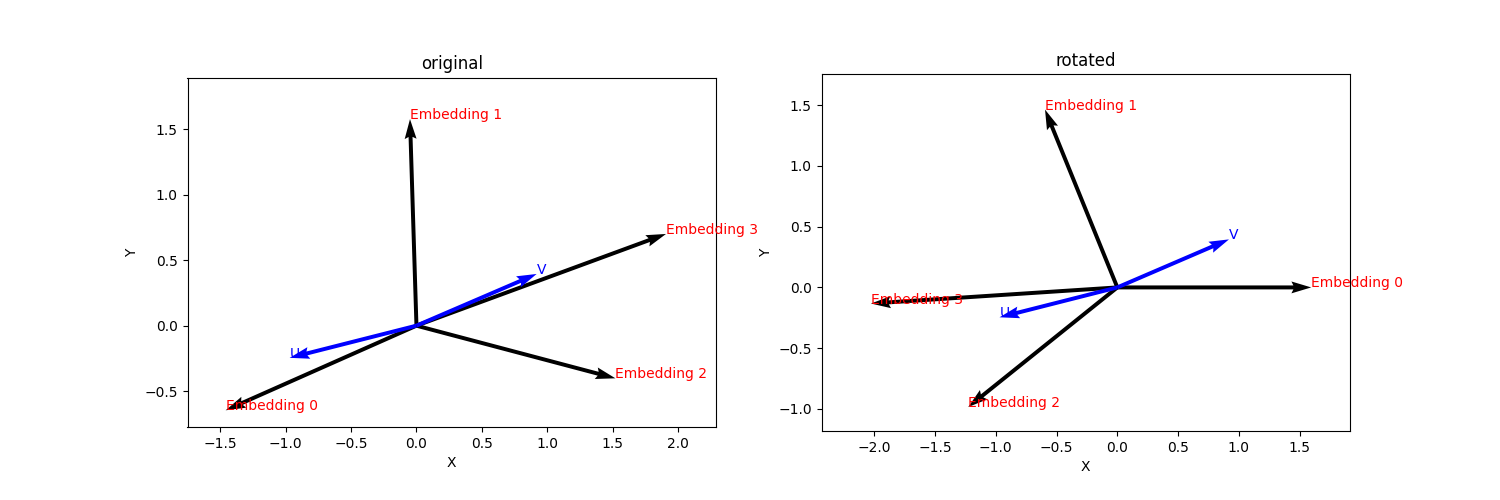

In [12]:
import matplotlib.pyplot as plt
import numpy as n

%matplotlib widget

plt.close('all')

def plot_tensor(fig, tensor, position = 111, title = ""):
    ax = fig.add_subplot(position)
    ax.set_title(title)

    # Define the origin
    origin = np.zeros((p+1, 2))

    # Plot the arrows
    for i in range(tensor.shape[0]):
        ax.quiver(origin[i, 0], origin[i, 1], 
                tensor[i, 0], tensor[i, 1],
                angles='xy', scale_units='xy', scale=1)

        ax.text(tensor[i, 0], tensor[i, 1], f"Embedding {i}", color='red')
    W_Q = model.blocks[0].attn.W_Q.data[0]
    W_K = model.blocks[0].attn.W_K.data[0].transpose(0, 1)
    W_QK = torch.matmul(W_Q, W_K)
    U, S, V = np.linalg.svd(W_QK.cpu())
    print("U=", U, "\nS=", S, "\nV=", V)
    
    ax.quiver(origin[i, 0], origin[i, 1], U[0, 0], U[0, 1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.text(U[0, 0], U[0, 1], f"U", color='blue')
    ax.quiver(origin[i, 0], origin[i, 1], V[0, 0], V[0, 1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.text(V[0, 0], V[0, 1], f"V", color='blue')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(min(tensor[:, 0].min(), 0)*1.2, max(tensor[:, 0].max(), 0) * 1.2)
    ax.set_aspect('equal')
    ax.set_ylim(min(tensor[:, 1].min(), 0)*1.2, max(tensor[:, 1].max(), 0) * 1.2)

fig = plt.figure(figsize=(15, 5))
plot_tensor(fig, W_E, 121, "original")
plot_tensor(fig, R.transpose(), 122, "rotated")
plt.show()

# Unembedding weights

In [13]:
W_U = model.unembed.W_U.data.cpu().numpy()

print(W_U)

Qrev, Rrev = qr(W_U)

print("Q_U=", Qrev)
print("R_U=", Rrev)

print("W_E=", W_E)
print("W_U=", W_U)

product = np.matmul(W_E, W_U)
print(product)

rank = np.linalg.matrix_rank(product)
print(rank)

[[ 0.32523656 -1.862302    0.0097143 ]
 [-1.1994034  -0.13433813  1.4328108 ]]
Q_U= [[-0.26171398  0.9651456 ]
 [ 0.9651456   0.2617138 ]]
R_U= [[-1.2427176   0.35773456  1.3803287 ]
 [ 0.         -1.8325506   0.38436198]]
W_E= [[-1.4582372  -0.6467691 ]
 [-0.04940346  1.5787361 ]
 [ 1.5207148  -0.40237457]
 [ 1.9072309   0.7009659 ]]
W_U= [[ 0.32523656 -1.862302    0.0097143 ]
 [-1.1994034  -0.13433813  1.4328108 ]]
[[ 0.301465    2.8025637  -0.9408635 ]
 [-1.9096093  -0.12008028  2.2615502 ]
 [ 0.97720146 -2.7779758  -0.561754  ]
 [-0.22043967 -3.6460063   1.0228789 ]]
2


# Activations

In [14]:
def create_cache(model, p = p):
    input = torch.stack([torch.arange(p), torch.full((p,), p)], dim=1)
    print(input)
    logits, cache = model.run_with_cache(input)
    print(logits)
    return cache

cache = create_cache(model)

tensor([[0, 3],
        [1, 3],
        [2, 3]])
tensor([[[  7.6760,  -6.8209,  -7.5588],
         [  7.1541, -13.2695,  -5.5950]],

        [[ -5.6793,  17.7801,   2.9219],
         [ -4.0146,  14.2233,   1.7184]],

        [[ -4.0091,  -5.0040,   5.7446],
         [ -5.4214,  -5.2141,   7.4427]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [15]:
W_K = model.blocks[0].attn.W_K.data[0].cpu()
W_Q = model.blocks[0].attn.W_Q.data[0].cpu()
print("W_K: ", W_K)
W_K_T = torch.transpose(W_K, 0, 1)
W_QK = torch.matmul(W_Q, W_K_T)
print("W_Q: ", W_Q)
print("W_K transposed: ", W_K_T)
print(W_QK)
W_V = model.blocks[0].attn.W_V.data[0].cpu()
W_O = model.blocks[0].attn.W_O.data[0].cpu()
W_VO = torch.matmul(W_V, W_O)
print(W_VO)
W_E = model.embed.W_E.data.cpu().numpy()
U, S, V = np.linalg.svd(W_QK)
print("U: ", U)
print("S: ", S)
print("V: ", V)
S_rank_1 = np.zeros((2, 2))
S_rank_1[0, 0] = S[0]
print("S_rank_1: ", S_rank_1)
W_QK_rank_1 = np.matmul(np.matmul(U, S_rank_1), V)
print("W_QK_rank_1: ", W_QK_rank_1)

W_K:  tensor([[ 1.3013, -1.2104],
        [ 0.5091, -0.5891]])
W_Q:  tensor([[-0.9874,  0.8546],
        [-0.5380, -0.0819]])
W_K transposed:  tensor([[ 1.3013,  0.5091],
        [-1.2104, -0.5891]])
tensor([[-2.3193, -1.0062],
        [-0.6009, -0.2256]])
tensor([[-1.0485,  3.0035],
        [-6.1452,  0.4274]])
U:  [[-0.9693127  -0.24583095]
 [-0.24583095  0.9693127 ]]
S:  [2.6081567  0.03117443]
V:  [[ 0.9185931   0.39520463]
 [-0.39520463  0.9185931 ]]
S_rank_1:  [[2.60815668 0.        ]
 [0.         0.        ]]
W_QK_rank_1:  [[-2.32231312 -0.99912453]
 [-0.58897034 -0.25339163]]


In [16]:
cache.cache_dict

{'hook_embed': tensor([[[-1.1464, -0.7083],
          [ 0.5219,  0.6230]],
 
         [[ 0.2624,  1.5172],
          [ 0.5219,  0.6230]],
 
         [[ 1.8326, -0.4639],
          [ 0.5219,  0.6230]]], device='cuda:0'),
 'hook_pos_embed': tensor([[[-0.3119,  0.0615],
          [ 1.3853,  0.0779]],
 
         [[-0.3119,  0.0615],
          [ 1.3853,  0.0779]],
 
         [[-0.3119,  0.0615],
          [ 1.3853,  0.0779]]], device='cuda:0'),
 'blocks.0.hook_resid_pre': tensor([[[-1.4582, -0.6468],
          [ 1.9072,  0.7010]],
 
         [[-0.0494,  1.5787],
          [ 1.9072,  0.7010]],
 
         [[ 1.5207, -0.4024],
          [ 1.9072,  0.7010]]], device='cuda:0'),
 'blocks.0.attn.hook_q': tensor([[[[ 1.7878, -1.1933]],
 
          [[-2.2603,  1.5726]]],
 
 
         [[[-0.8006, -0.1716]],
 
          [[-2.2603,  1.5726]]],
 
 
         [[[-1.2850,  1.3326]],
 
          [[-2.2603,  1.5726]]]], device='cuda:0'),
 'blocks.0.attn.hook_k': tensor([[[[-2.2269,  2.1461]],
 
          [[ 

# Animations

In [17]:
from manim import *

config.media_width = "80%"
config.verbosity = "WARNING"
config.preview = False

In [18]:
class VectorParams:
    def __init__(self, values = [], color = WHITE):
        self.values = values
        self.color = color
    def __repr__(self) -> str:
        return str(self.values) + "(" + str(self.color) + ")"

class Data:
    def __init__(self):
        self.vectors: list[list[VectorParams]] = [[]]
        self.steps = 0

    def add_vector(self, vector, color = WHITE):
        self.vectors[self.steps].append(VectorParams(values = vector, color = color))

    def next_step(self):
        self.steps += 1
        self.vectors.append([])

    def add_vectors_at_hook(self, c: ActivationCache, hook: str, color0 = WHITE, color1 = WHITE):
        for i in range(c.cache_dict[hook].shape[0]):
            self.add_vector(c.cache_dict[hook][i][0].cpu(), color = color0)
            self.add_vector(c.cache_dict[hook][i][1].cpu(), color = color1)

def compile_data_vectors(cache):
    vectors = Data()
    vectors.add_vectors_at_hook(cache, "hook_embed", color1 = GRAY)
    vectors.next_step()
    vectors.add_vectors_at_hook(cache, "blocks.0.hook_resid_pre")
    vectors.next_step()
    vectors.add_vectors_at_hook(cache, "blocks.0.hook_resid_mid", color0 = GRAY)
    #vectors.add_vectors_at_hook(cache, "blocks.0.hook_resid_post")

    print(vectors.vectors)
    return vectors
vectors = compile_data_vectors(cache)

[[tensor([-1.1464, -0.7083])(#FFFFFF), tensor([0.5219, 0.6230])(#888888), tensor([0.2624, 1.5172])(#FFFFFF), tensor([0.5219, 0.6230])(#888888), tensor([ 1.8326, -0.4639])(#FFFFFF), tensor([0.5219, 0.6230])(#888888)], [tensor([-1.4582, -0.6468])(#FFFFFF), tensor([1.9072, 0.7010])(#FFFFFF), tensor([-0.0494,  1.5787])(#FFFFFF), tensor([1.9072, 0.7010])(#FFFFFF), tensor([ 1.5207, -0.4024])(#FFFFFF), tensor([1.9072, 0.7010])(#FFFFFF)], [tensor([ 4.0452, -5.3029])(#888888), tensor([ 7.4106, -3.9552])(#FFFFFF), tensor([-9.6992,  2.1051])(#888888), tensor([-7.7278,  1.2517])(#FFFFFF), tensor([2.3990, 3.9931])(#888888), tensor([2.4263, 5.1780])(#FFFFFF)]]


In [19]:
def change_font_size(labeled_arrow: LabeledArrow, new_size):
    # print(labeled_arrow, labeled_arrow.submobjects)
    # print(labeled_arrow.submobjects[-1].font_size)
    if not isinstance(labeled_arrow, LabeledArrow):
        return
    label = labeled_arrow.submobjects[-1]
    box = labeled_arrow.submobjects[-2]
    if not isinstance(box, BackgroundRectangle):
        box = labeled_arrow.submobjects[-3]
    coords = label.get_center()
    # print(new_size)
    labeled_arrow.submobjects[-1] = MathTex(
        label.get_tex_string(), color=label.color, font_size=new_size
    )
    # print("size=", labeled_arrow.submobjects[-1].font_size)
    label = labeled_arrow.submobjects[-1]
    label.move_to(coords)
    box.width = label.width + 2 * box.buff
    box.height = label.height + 2 * box.buff

In [20]:
class VisualizeTransformer(MovingCameraScene):
    def construct(self):
        print("v=", vectors.vectors)
        axes = Axes(
            x_range = [-20, 20, 1],
            y_range = [-20, 20, 1],
            x_axis_config={
                "numbers_to_include": np.arange(-18, 18.1, 3),
                "font_size": 24
            },
            y_axis_config={
                "numbers_to_include": np.arange(-18, 18.1, 3), 
                "font_size": 24            
            },
            x_length = 40,
            y_length = 40,
            axis_config={"color": GREEN}
        )
        axes_labels = axes.get_axis_labels()

        scale = ValueTracker(2)

        arrows = VGroup()
        def update_scale(self):
            self.stroke_width = 6 * scale.get_value()
            change_font_size(self, 48 * scale.get_value())
            # print("New font size: ", self.font_size)

        # Embedding arrows
        for i, t in enumerate(vectors.vectors[0]):
            # print(t, t.numpy())
            arrow = LabeledArrow(
                start=ORIGIN,
                end=np.append(t.values.numpy(), 0),
                buff = 0,
                label = str(i//2) if i%2==0 else str(i//2) + "=",
                label_frame = False,
                label_color=YELLOW,
                color = t.color,
                max_stroke_width_to_length_ratio = 100,
            )

            arrow.add_updater(update_scale)
            arrows.add(arrow)

        # Transitioing the arrows through the model
        self.add(axes, axes.get_axis_labels(), arrows)
        for step in range(1, len(vectors.vectors)):
            new_arrows = VGroup()
            transition_arrows = VGroup()
            for i, t in enumerate(vectors.vectors[step]):
                # print(t, t.numpy())
                new_arrow = LabeledArrow(
                    start=ORIGIN,
                    end=np.append(t.values.numpy(), 0),
                    buff=0,
                    label=str(i // 2) if i % 2 == 0 else str(i // 2) + "=",
                    label_frame=False,
                    label_color=YELLOW,
                    color=t.color,
                    max_stroke_width_to_length_ratio=100,
                )
                new_arrow.add_updater(update_scale)
                new_arrows.add(new_arrow)
                transition_arrow = Arrow(
                    start=arrows[i].end, end=new_arrows[i].end, buff=0, color=RED
                )
                transition_arrow.add_updater(update_scale)
                transition_arrows.add(transition_arrow)

            view = SurroundingRectangle(new_arrows)
            factor = max(
                view.width / self.camera.frame_width,
                view.height / self.camera.frame_height,
            )
            print(
                factor,
                self.camera.frame_width, view.width,
                self.camera.frame_height, view.height,
            )
            self.wait()
            self.play(FadeIn(transition_arrows), self.camera.auto_zoom(view, margin = 2), scale.animate.set_value(scale.get_value() * factor))
            self.wait()
            self.play(
                ReplacementTransform(arrows, new_arrows)
            )
            self.wait()
            self.play(FadeOut(transition_arrows))
            self.wait()
            arrows = new_arrows

        # Unembedding Arrows
        embedding_arrows = VGroup()
        data = model.W_U.data
        for i in range(model.W_U.data.size()[1]):
            embedding_arrow = LabeledArrow(
                start=ORIGIN,
                end=[data[0, i].item(), data[1, i].item(), 0],
                label=str(i),
                color=BLUE,
            )
            embedding_arrows.add(embedding_arrow)
        self.play(FadeIn(embedding_arrows))
        self.wait()

# v = VisualizeTransformer()
# v.construct()

In [57]:
%%manim -ql -p Video

p = 7
train_data, train_labels, test_data, test_labels, train_indices, test_indices = get_training_data(p)
model = get_seeded_model(999, p = p)
train_model(model, train_data, train_labels, test_data, test_labels, train_indices, test_indices)
cache = create_cache(model, p = p)
vectors = compile_data_vectors(cache)

class Video(VisualizeTransformer):
    def construct(self):
        VisualizeTransformer.construct(self)

tensor([[0, 7],
        [1, 7],
        [2, 7],
        [3, 7],
        [4, 7],
        [5, 7],
        [6, 7]], device='cuda:0')
torch.Size([7, 2])
torch.Size([7])
tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([[3, 7],
        [2, 7],
        [5, 7],
        [1, 7],
        [0, 7],
        [6, 7],
        [4, 7]], device='cuda:0')
tensor([3, 2, 5, 1, 0, 6, 4], device='cuda:0')
torch.Size([7, 2])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
tensor([], device='cuda:0', dtype=torch.int64)
torch.Size([0, 2])


  0%|          | 0/10000 [00:00<?, ?it/s]

Angle between 0 and 1: 17.46°
Angle between 0 and 2: 104.67°
Angle between 0 and 3: 77.11°
Angle between 0 and 4: 173.74°
Angle between 0 and 5: 70.04°
Angle between 0 and 6: 168.79°
Norm of vector 0: 0.55
Angle between 1 and 2: 122.13°
Angle between 1 and 3: 59.65°
Angle between 1 and 4: 168.80°
Angle between 1 and 5: 52.58°
Angle between 1 and 6: 173.75°
Norm of vector 1: 1.28
Angle between 2 and 3: 178.22°
Angle between 2 and 4: 69.07°
Angle between 2 and 5: 174.71°
Angle between 2 and 6: 64.12°
Norm of vector 2: 0.90
Angle between 3 and 4: 109.16°
Angle between 3 and 5: 7.07°
Angle between 3 and 6: 114.10°
Norm of vector 3: 0.89
Angle between 4 and 5: 116.22°
Angle between 4 and 6: 4.95°
Norm of vector 4: 1.79
Angle between 5 and 6: 121.17°
Norm of vector 5: 2.13
Norm of vector 6: 1.63
Epoch 499 Train Loss 1.027136296076084 Test Loss nan
Angle between 0 and 1: 55.35°
Angle between 0 and 2: 74.36°
Angle between 0 and 3: 124.90°
Angle between 0 and 4: 157.63°
Angle between 0 and 5: 9

Manim Community v0.18.1

v= [[tensor([-2.1179, -0.2928])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([-1.3001,  1.7319])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([-1.8608, -2.6382])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([2.3145, 0.8587])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([ 2.3990, -0.6693])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([0.8931, 2.2717])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([ 0.5295, -2.2243])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888)], [tensor([-2.8232,  0.0560])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([-2.0053,  2.0808])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([-2.5660, -2.2894])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([1.6092, 1.2075])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([ 1.6938, -0.3205])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([0.1879, 2.6205])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([-0.1758, -1.8754])(#FFFFFF), te

3.775909818894609 12.649671967426936 38.75948543548584 7.109885883331299 26.846287918090823


[00005e648d7ab640] main libvlc: VLC wird mit dem Standard-Interface ausgeführt. Benutzen Sie 'cvlc', um VLC ohne Interface zu verwenden.


[00007a2c64004510] gl gl: Initialized libplacebo v4.192.1 (API v192)
libva info: VA-API version 1.20.0
libva error: vaGetDriverNames() failed with unknown libva error
[00007a2c64004510] glconv_vaapi_x11 gl error: vaInitialize: unknown libva error
libva info: VA-API version 1.20.0
libva info: Trying to open /usr/lib/x86_64-linux-gnu/dri/iHD_drv_video.so
libva info: Found init function __vaDriverInit_1_19
libva info: va_openDriver() returns 0
[00007a2c6c0496e0] main video output error: video output creation failed
[00007a2c78c19b20] main decoder error: failed to create video output
[00007a2c64004510] gl gl: Initialized libplacebo v4.192.1 (API v192)
[00007a2c78c19b20] avcodec decoder: Using NVIDIA VDPAU Driver Shared Library  550.90.12  Thu Aug 29 05:29:07 UTC 2024 for hardware decoding
[00007a2c64004510] gl gl: Initialized libplacebo v4.192.1 (API v192)
[00007a2c64004510] gl gl: Initialized libplacebo v4.192.1 (API v192)
[00007a2c78c5e730] avcodec decoder: Using NVIDIA VDPAU Driver Shar

# Manually Improving the model

In [62]:
import copy

out_vectors = cache.cache_dict["blocks.0.hook_resid_post"][:, 1, :].transpose(0, 1)
unembed_vectors = model.W_U.data
print(out_vectors)
modified_vectors = (
    out_vectors
    / out_vectors.norm(dim=0, keepdim=True)
    * unembed_vectors.norm(dim=0, keepdim=True)
)
print(modified_vectors)
print(unembed_vectors)
modified_model = copy.deepcopy(model)
modified_model.W_U.data = modified_vectors

logits1 = model(train_data)
logits2 = modified_model(train_data)
loss1 = loss_fn(logits1, train_labels)
loss2 = loss_fn(logits2, train_labels)
print(logits1[:,1,:], train_labels)
print(logits2[:,1,:], train_labels)
print(loss1, loss2)

tensor([[-13.2734,  -1.4530, -20.8419,  13.4516,   6.0903,  11.6854,  -6.3257],
        [  7.8943,  13.6794,  -2.7878,  -1.9165,  -9.1003,   8.7167,  -9.2485]],
       device='cuda:0')
tensor([[-1.5770, -0.2444, -1.7087,  2.2150,  1.4912,  1.8588, -1.4440],
        [ 0.9379,  2.3013, -0.2286, -0.3156, -2.2282,  1.3866, -2.1112]],
       device='cuda:0')
tensor([[-1.5770, -0.2444, -1.7087,  2.2150,  1.4912,  1.8588, -1.4440],
        [ 0.9379,  2.3013, -0.2286, -0.3156, -2.2282,  1.3866, -2.1112]],
       device='cuda:0')
tensor([[-23.0100,  -7.6986, -22.5473,  30.3997,  24.3297,  22.3463, -15.3781],
        [ 30.2520,  -1.3210,  36.2504, -45.2843, -24.8681, -42.6058,  35.9809],
        [-10.2520,  17.2038, -21.9595,  23.1321,  -1.9973,  33.8068, -35.2761],
        [ 15.1210,  31.8362,  -0.6438,  -7.5351, -32.6476,  16.2665, -26.7814],
        [ 28.3354,  21.4120,  20.8763, -31.8912, -37.3838, -13.7264,   2.5005],
        [  1.3014, -19.7376,  12.9228, -11.0928,  11.1746, -24.5817,  28.

tensor(0.0819, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)

In [55]:
%%manim -ql -p Video

cache = create_cache(model, p = 7)
vectors = compile_data_vectors(cache)

class Video(VisualizeTransformer):
    def construct(self):
        VisualizeTransformer.construct(self)

tensor([[0, 7],
        [1, 7],
        [2, 7],
        [3, 7],
        [4, 7],
        [5, 7],
        [6, 7]])
tensor([[[ 35.6210,  26.1928,  26.6625, -40.4278, -46.5451, -18.0933,   4.1417],
         [ 28.3354,  21.4120,  20.8763, -31.8912, -37.3838, -13.7264,   2.5005]],

        [[ 23.0158,  41.0766,   3.2820, -14.8990, -45.1008,  16.2272, -30.5958],
         [ 15.1210,  31.8362,  -0.6438,  -7.5351, -32.6476,  16.2665, -26.7814]],

        [[ 34.9973,  -1.9603,  42.1860, -52.5883, -28.5001, -49.7883,  42.2200],
         [ 30.2520,  -1.3210,  36.2504, -45.2843, -24.8681, -42.6058,  35.9809]],

        [[-21.6920,  -1.2834, -24.7052,  31.4344,  19.2193,  27.9719, -22.7271],
         [-23.0100,  -7.6986, -22.5473,  30.3997,  24.3297,  22.3463, -15.3781]],

        [[-21.0492, -18.8729, -13.7952,  22.3122,  29.6167,   6.7675,   2.2294],
         [-18.1392, -22.4316,  -8.3268,  16.3616,  29.3596,  -1.2976,  10.4179]],

        [[ -5.3096,  27.1504, -21.9048,  20.4558, -12.3826,  38.592

Manim Community v0.18.1

v= [[tensor([-2.1179, -0.2928])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([-1.3001,  1.7319])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([-1.8608, -2.6382])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([2.3145, 0.8587])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([ 2.3990, -0.6693])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([0.8931, 2.2717])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888), tensor([ 0.5295, -2.2243])(#FFFFFF), tensor([ 0.1428, -0.6858])(#888888)], [tensor([-2.8232,  0.0560])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([-2.0053,  2.0808])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([-2.5660, -2.2894])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([1.6092, 1.2075])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([ 1.6938, -0.3205])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([0.1879, 2.6205])(#FFFFFF), tensor([ 0.7895, -1.6376])(#FFFFFF), tensor([-0.1758, -1.8754])(#FFFFFF), te

3.775909818894609 12.649671967426936 38.75948543548584 7.109885883331299 26.846287918090823


[000058617114c640] main libvlc: VLC wird mit dem Standard-Interface ausgeführt. Benutzen Sie 'cvlc', um VLC ohne Interface zu verwenden.


[00007803d0004510] gl gl: Initialized libplacebo v4.192.1 (API v192)
libva info: VA-API version 1.20.0
libva error: vaGetDriverNames() failed with unknown libva error
[00007803d0004510] glconv_vaapi_x11 gl error: vaInitialize: unknown libva error
libva info: VA-API version 1.20.0
libva info: Trying to open /usr/lib/x86_64-linux-gnu/dri/iHD_drv_video.so
libva info: Found init function __vaDriverInit_1_19
libva info: va_openDriver() returns 0
[00007803d80496e0] main video output error: video output creation failed
[00007803e4c199d0] main decoder error: failed to create video output
[00007803d0560cd0] gl gl: Initialized libplacebo v4.192.1 (API v192)
[00007803e4c199d0] avcodec decoder: Using NVIDIA VDPAU Driver Shared Library  550.90.12  Thu Aug 29 05:29:07 UTC 2024 for hardware decoding
[00007803d03d4250] gl gl: Initialized libplacebo v4.192.1 (API v192)
[00007803d03d4250] gl gl: Initialized libplacebo v4.192.1 (API v192)
[00007803e4c5b380] avcodec decoder: Using NVIDIA VDPAU Driver Shar